<a href="https://colab.research.google.com/github/dp22acn/Time_series_modelling/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Devendra Sai Peddoju
ID: 22027731

# **Image Segmentation Using Mask Rcnn**

Mask Rcnn Frame Work For Instant Segmentation

citation: K. He, G. Gkioxari, P. Dollár and R. Girshick, "Mask R-CNN," 2017 IEEE International Conference on Computer Vision (ICCV), Venice, Italy, 2017, pp. 2980-2988, doi: 10.1109/ICCV.2017.322. keywords: {Feature extraction;Image segmentation;Object detection;Semantics;Quantization (signal);Robustness},



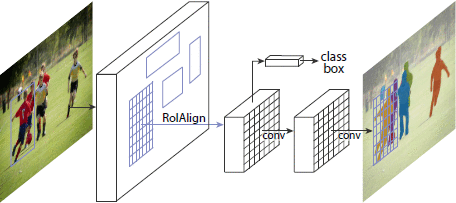

DataSet: Using a Sub set of Coco 2017 Dataset
link to Data set: https://drive.google.com/file/d/1-51jtgTpHDeK8os0GaraF2mocS460xFD/view?usp=sharing

citation: @article{lin2014microsoft,
  title={Microsoft COCO: Common Objects in Context},
  author={Lin, Tsung-Yi and Maire, Michael and Belongie, Serge and Hays, James and Perona, Pietro and Ramanan, Deva and Dollár, Piotr and Zitnick, C Lawrence},
  journal={arXiv preprint arXiv:1405.0312},
  year={2014}
}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Importing and unpacking the data set
!unzip /content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip -d data_set

**Installing Necessary Libabires like Torch Vision can be useful for image processing and gives us acess to use pretrained models for the analysis**

**pycocotools is specialized for handling COCO-style datasets, essential for loading, processing, and evaluating your segmentation tasks.**

citation and credits:
@inproceedings{paszke2019pytorch,
  title={PyTorch: An Imperative Style, High-Performance Deep Learning Library},
  author={Paszke, Adam and Gross, Sam and Massa, Francisco and Lerer, Adam and Bradbury, James and Chanan, Gregory and Killeen, Trevor and Lin, Zeming and Gimelshein, Natalia and Antiga, Luca and others},
  booktitle={Advances in Neural Information Processing Systems},
  volume={32},
  year={2019}
}

TorchVision: https://github.com/pytorch/vision

In [ ]:
!pip install torch torchvision pycocotools #installing the libraries

Importing required Lib for the Project

In [ ]:
import os
from pycocotools.coco import COCO
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib import patches
from pycocotools import mask as coco_mask

In [ ]:
# Defining the categories of interest dynamically
classes_of_interest = {
    "vehicle": ["truck", "car"],
    "nature": ["road"],
    "human": ["person"]
}

# Flattenimg  the dictionary to get a list of all class names
selected_classes = [cls for sublist in classes_of_interest.values() for cls in sublist]
print("Classes of interest:", selected_classes)

Acessing the Data Set it Improves the Scalibility, you can modify the function instead of updating multiple hardcoded values.

In [ ]:
import os

def get_dataset_paths(base_dir):
    """
    Generating dataset pathsv.

    Args:
        base_dir (str): The root directory of the dataset.

    Returns:
        dict: A dictionary containing paths to training, validation, and test datasets.
    """
    paths = {
        "train_images_dir": os.path.join(base_dir, "train-300", "data"),
        "train_annotations_path": os.path.join(base_dir, "train-300", "labels.json"),
        "val_images_dir": os.path.join(base_dir, "validation-300", "data"),
        "val_annotations_path": os.path.join(base_dir, "validation-300", "labels.json"),
        "test_images_dir": os.path.join(base_dir, "test-30")
    }
    return paths

# Set the base directory for the dataset
data_dir = "/content/data_set"
dataset_paths = get_dataset_paths(data_dir)

# Access the paths
train_images_dir = dataset_paths["train_images_dir"]
train_annotations_path = dataset_paths["train_annotations_path"]
val_images_dir = dataset_paths["val_images_dir"]
val_annotations_path = dataset_paths["val_annotations_path"]
test_images_dir = dataset_paths["test_images_dir"]

print("Dataset paths:")
for key, path in dataset_paths.items():
    print(f"{key}: {path}")


**Creating Instance Annotations For our Data it helps us to find the different instances for the same class by Using Functions Like bound Boxes and segmentation Masks.**

In [ ]:
from pycocotools.coco import COCO

# Initialize COCO API for instance annotations
coco = COCO(train_annotations_path)
cat_ids = coco.getCatIds()
categories = coco.loadCats(cat_ids)


def load_coco_categories(train_annotations_path):
    """
    This function Initialize the COCO API for instance annotations and load category information.

    Args:
        annotations_path (str): Path to the annotation file

    Returns:
        tuple: A tuple containing:
            - names_cats (list): A list of category names.
            - names_scats (set): A set of unique supercategory names.
    """
    # Load category IDs and category details
    cat_ids = coco.getCatIds()
    categories = coco.loadCats(cat_ids)

    # Extract category names
    names_cats = [cats["name"] for cats in categories]
    print(len(names_cats), "COCO categories:", " ".join(names_cats))

    # Extract unique supercategory names
    names_scats = set([cats["supercategory"] for cats in categories])
    print(len(names_scats), "COCO supercategories:", " ".join(names_scats))

    return names_cats, names_scats,


load_coco_categories(train_annotations_path)


# Ensuring Data Distrubution And Quality
by calculating the number of images in our class of intrest
**The goal is to count the number of images that have at least one instance of each category.**

In [ ]:
from collections import defaultdict

def get_category_image_counts(coco, classes_of_interest):
    """
    Calculate the number of images containing specified categories in the dataset.

    Args:
        coco (COCO): Initialized COCO API instance.
        classes_of_interest (list): List of category names to count in the dataset.

    Returns:
        dict: A dictionary mapping category names to the count of images containing that category.
    """
    # Dictionary to store the number of images per category
    category_image_counts = defaultdict(int)

    for category in classes_of_interest:
        # Retrieve category IDs for the category
        category_IDs = coco.getCatIds(catNms=[category])

        if category_IDs:  # Ensure category exists in the dataset
            # Get all image IDs for the category
            image_IDs = coco.getImgIds(catIds=category_IDs)
            category_image_counts[category] = len(image_IDs)
            print(f"Number of images containing {category} category: {len(image_IDs)}.")
        else:
            # If category does not exist, report 0
            category_image_counts[category] = 0
            print(f"{category} category not found in the dataset.")

    return category_image_counts

# Example usage
# Define more categories if needed (adjust based on the dataset)
classes_of_interest = ["truck", "car", "tree", "person", "dog", "cat", "bicycle", "train", "traffic light"]
category_counts = get_category_image_counts(coco, classes_of_interest)


Displaying The Categories Plot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("Set2", len(classes_of_interest))
fig, ax = plt.subplots(figsize=(15, 8))
bars = ax.bar(category_counts.keys(), category_counts.values(), color=colors)

# Adding count labels
for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12)

# Adding legend
ax.legend(bars, category_counts.keys(), loc='upper left', bbox_to_anchor=(1, 1))

# Adding labels
ax.set_xlabel('Category', fontsize=14)
ax.set_ylabel('Number of Images', fontsize=14)
ax.set_title('Number of Images Containing Each Specified Category', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()


# loading and displaying a random image along with its corresponding instance annotations from the COCO dataset
This part includes fetching random Imags and loading theis instance annotations

In [ ]:
# Number of images to display
num_images = 4

# Preparing the figure for displaying original and annotated images
fig, axes = plt.subplots(num_images, 2, figsize=(15, 5 * num_images))
axes = axes.flatten()  # Flattening axes for easier indexing

for i in range(num_images):
    img_ids = coco.getImgIds()
    img_id = random.choice(img_ids)  # Chooses a random image ID
    img_info = coco.loadImgs(img_id)[0]  # Get the image info

    image_path = os.path.join(train_images_dir, img_info['file_name'])

    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Load instance annotations
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    # Display the original image
    ax = axes[2 * i]  # Even-indexed axes for original image
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"Original Image\nID: {img_info['id']}")

    # Display the image with annotations
    ax = axes[2 * i + 1]  # Odd-indexed axes for annotated image
    ax.imshow(image)
    ax.axis('off')

    if anns:
        for ann in anns:
            # Get bounding box and category info
            bbox = ann['bbox']
            category_id = ann['category_id']
            category_name = coco.loadCats([category_id])[0]['name']

            # Drawing the bounding box
            rect = patches.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3],
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

            # Adding the category label
            ax.text(bbox[0], bbox[1], category_name, color='red', fontsize=10, weight='bold')

            # If the annotation has a segmentation mask, view it
            if 'segmentation' in ann and isinstance(ann['segmentation'], list):
                for seg in ann['segmentation']:
                    # Decode the segmentation polygons
                    poly = np.array(seg).reshape((int(len(seg) / 2), 2))  # Reshape into (N, 2) points
                    ax.fill(poly[:, 0], poly[:, 1], alpha=0.5, facecolor='yellow', edgecolor='red')

        ax.set_title(f"Annotated Image\nID: {img_info['id']}")
    else:
        ax.set_title(f"Annotated Image\nID: {img_info['id']}\nNo annotations")

plt.tight_layout()
plt.show()


# Loading Lib For segmentation
**torch** is a framework used to create deep learning models and computation
citation: Paszke, A., Gross, S., & Chintala, S. (2017). Automatic differentiation in PyTorch. In NIPS 2017.

# Mask Rcnn Resnet50 Fpn
This is a pre-trained Mask R-CNN model with a ResNet-50 backbone and Feature Pyramid Networks (FPN), specifically designed for instance segmentation.

Citation:He, K., Gkioxari, G., Dollár, P., & Girshick, R. (2017). Mask R-CNN. In ICCV 2017.


In [ ]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
class IMG_SEG_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path)).convert("RGB")

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        masks = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            if 'segmentation' in coco_annotation[i] and len(coco_annotation[i]['segmentation']) > 0:
                try:
                    mask = coco.annToMask(coco_annotation[i])
                    masks.append(mask)
                except Exception as e:
                    print(f"Error creating mask for annotation {coco_annotation[i]}: {e}")
                    masks.append(torch.zeros((img.height, img.width), dtype=torch.uint8))
            else:
                # Create an empty mask if no valid segmentation is available
                masks.append(torch.zeros((img.height, img.width), dtype=torch.uint8))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if len(masks) > 0:
            masks = np.stack(masks, axis=0)
            masks = torch.as_tensor(masks, dtype=torch.uint8)
        else:
            masks = torch.zeros((0, img.height, img.width), dtype=torch.uint8)
        # Labels
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd
        my_annotation["masks"] = masks

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [ ]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [ ]:
# Define the desired classes
desired_classes = ["truck", "car", "tree", "person", "dog", "cat", "bicycle", "train", "traffic light"]

# Load COCO dataset
train_dataset = IMG_SEG_Dataset(train_images_dir,
                             train_annotations_path,
                             get_transform())

val_dataset = IMG_SEG_Dataset(val_images_dir,
                           val_annotations_path,
                           get_transform())

In [ ]:
# Filter COCO dataset for desired classes based on names
target_class_ids = train_dataset.coco.getCatIds(catNms=desired_classes)
train_dataset.ids = [img_id for img_id in train_dataset.ids if
                     any(annotation['category_id'] in target_class_ids for annotation in
                         train_dataset.coco.loadAnns(train_dataset.coco.getAnnIds(imgIds=img_id)))]

target_class_ids = val_dataset.coco.getCatIds(catNms=desired_classes)
val_dataset.ids = [img_id for img_id in val_dataset.ids if
                   any(annotation['category_id'] in target_class_ids for annotation in
                       val_dataset.coco.loadAnns(val_dataset.coco.getAnnIds(imgIds=img_id)))]

# Check if there are images left after filtering
if len(train_dataset) == 0 or len(val_dataset) == 0:
    raise ValueError("No images found for the specified classes. Please check your filtering criteria.")

num_classes = len(desired_classes) + 1

# **Model Architecture** MaskRCNN

**Back Bone: Using ResNet50 paird with Fpn**

**Region PRoposal Network(RPN): is a fully convolutional network itgenerates regions and outputs both bound box co-ordinates and objectness score**

**ROI align: After RPN generates regions using ROI aglin to extract feature maps from those regions**

**Classifier: Box Classifier**

**predictor: Mask predictor**

Source Credits:
Mask R-CNN Paper: https://arxiv.org/abs/1703.06870
Torchvision Documentation: https://pytorch.org/vision/stable/index.html#torchvision
ResNet Architecture:https://arxiv.org/abs/1512.03385

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn


# Define the function to load your model with the specified number of classes
def get_image_segmentation(num_classes, pretrained=True):
    """
    Load a Mask R-CNN model with the specified number of classes.

    Args:
        num_classes (int): Number of classes (including background).
        pretrained (bool): Whether to load pre-trained weights or not.

    Returns:
        model: The Mask R-CNN model with custom classification and mask heads.
    """
    model = maskrcnn_resnet50_fpn(pretrained=pretrained)

    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the classifier head to match the desired number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Get number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 512
    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

# Define number of classes (background + your target classes)
num_classes = len(desired_classes) + 1  # Including background

# Instantiate the model
model = get_image_segmentation(num_classes, pretrained=True)

# Define collate_fn for batch processing (necessary for working with variable-sized inputs)
def collate_fn(batch):
    return tuple(zip(*batch))

# Define training and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)

# Example print of the model architecture
print(model)


In [ ]:
import torch

# Function to select device (GPU if available, otherwise CPU)
def get_device():
    if torch.cuda.is_available():
        # Use the first GPU
        device = torch.device("cuda:0")
        print(f"CUDA is available. Using device: {device}")
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Using CPU.")

    return device

# Function to move model to the appropriate device (GPU or CPU)
def move_model_to_device(model, device):
    # Moving the model to the selected device (GPU or CPU)
    model = model.to(device)
    print(f"Model moved to {device}.")
    return model

# Select the device (GPU or CPU)
device = get_device()

# Example: Moving the model to the selected device
model = move_model_to_device(model, device)


# **Optimizers and Learning Rate**
**Stochastic Gradient Descent (SGD)**
source:https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#sgd
citation:https://arxiv.org/abs/1412.6980

**Adam Optimizer**
source:https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#adam
citation:Kingma, D. P., & Ba, J. (2015). "Adam: A Method for Stochastic Optimization." International Conference on Learning Representations (ICLR). https://arxiv.org/abs/1412.6980

Learning Rate Scheduler: StepLR
source:https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#steplr
citation:Loshchilov, I., & Hutter, F. (2016). "SGDR: Stochastic Gradient Descent with Warm Restarts." International Conference on Machine Learning (ICML). https://arxiv.org/abs/1608.03983




In [ ]:
import torch

# Define the optimizer with a flexible learning rate and parameters
def get_optimizer(model, lr=0.005, momentum=0.9, weight_decay=0.0005, optimizer_type='SGD'):
    """
    Select and return the optimizer for the given model.

    Args:
    - model: PyTorch model.
    - lr: Learning rate.
    - momentum: Momentum for SGD.
    - weight_decay: Weight decay for regularization.
    - optimizer_type: Type of optimizer to use ('SGD', 'Adam', or 'AdamW').

    Returns:
    - optimizer: The selected optimizer.
    """
    # Filter parameters that require gradients
    params = [p for p in model.parameters() if p.requires_grad]

    # Create the optimizer based on the specified type
    if optimizer_type == 'SGD':
        optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
        print(f"Using SGD optimizer with lr={lr}, momentum={momentum}, weight_decay={weight_decay}")
    elif optimizer_type == 'Adam':
        optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
        print(f"Using Adam optimizer with lr={lr}, weight_decay={weight_decay}")
    elif optimizer_type == 'AdamW':
        optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
        print(f"Using AdamW optimizer with lr={lr}, weight_decay={weight_decay}")
    else:
        raise ValueError(f"Unknown optimizer type: {optimizer_type}")

    return optimizer

# Define the learning rate scheduler (StepLR, could be customized later)
def get_lr_scheduler(optimizer, step_size=3, gamma=0.1, scheduler_type='StepLR'):
    """
    Select and return the learning rate scheduler for the given optimizer.

    Args:
    - optimizer: The optimizer to apply the scheduler to.
    - step_size: Number of epochs after which the learning rate should be reduced.
    - gamma: The factor by which the learning rate will be multiplied.
    - scheduler_type: Type of learning rate scheduler ('StepLR', 'CosineAnnealingLR', or 'ReduceLROnPlateau').

    Returns:
    - lr_scheduler: The selected learning rate scheduler.
    """
    # Select the scheduler based on the specified type
    if scheduler_type == 'StepLR':
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        print(f"Using StepLR scheduler with step_size={step_size} and gamma={gamma}")
    elif scheduler_type == 'CosineAnnealingLR':
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
        print(f"Using CosineAnnealingLR scheduler with T_max=10, eta_min=0")
    elif scheduler_type == 'ReduceLROnPlateau':
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
        print(f"Using ReduceLROnPlateau scheduler with factor=0.1, patience=5")
    else:
        raise ValueError(f"Unknown scheduler type: {scheduler_type}")

    return lr_scheduler

# Example: Get optimizer and scheduler
optimizer = get_optimizer(model, lr=0.005, optimizer_type='SGD')
lr_scheduler = get_lr_scheduler(optimizer, step_size=3, gamma=0.1)


Training Loop

In [ ]:
from tqdm import tqdm  # Import tqdm for the progress bar

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    # Use tqdm to add a progress bar for the training loop
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for images, targets in pbar:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Move targets to device

            # Forward pass: calculate loss
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Backward pass: optimize the model
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            # Update the progress bar with the current loss
            pbar.set_postfix(loss=losses.item())  # Display loss in the progress bar

    # Update learning rate
    lr_scheduler.step()

    # Validate the model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Use tqdm to add a progress bar for the validation loop
        with tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation', unit='batch') as pbar_val:
            for images, targets in pbar_val:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # Move targets to device

                # Forward pass during validation
                model(images, targets)  # No gradient needed

                # You can optionally add validation loss visualization here if required
                pbar_val.set_postfix()

print("Training finished")


In [ ]:
import torch
from PIL import Image, ImageDraw
import torchvision.transforms as T
import random
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to perform inference and visualize results
def visualize_inference(model, test_images_dir, device, threshold=0.3, num_images=3):
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Ensure the model is on the correct device (GPU or CPU)

    # List all image files in the test directory
    image_files = [f for f in os.listdir(test_images_dir) if os.path.isfile(os.path.join(test_images_dir, f))]
    print(f"Found {len(image_files)} images in {test_images_dir}.")

    # Select random images
    if len(image_files) == 0:
        print("No images found in the test directory.")
        return

    selected_images = random.sample(image_files, min(num_images, len(image_files)))

    # Loop through each selected image for inference
    for image_file in selected_images:
        image_path = os.path.join(test_images_dir, image_file)
        print(f"Processing image: {image_file}")

        # Check if image exists
        if not os.path.exists(image_path):
            print(f"Image not found at path: {image_path}")
            continue

        image = Image.open(image_path).convert("RGB")  # Open image and convert to RGB

        # Transform the image to tensor and move to device
        image_tensor = T.ToTensor()(image).unsqueeze(0).to(device)

        # Perform inference with no gradient calculation
        with torch.no_grad():
            prediction = model(image_tensor)

        # Extract prediction results
        boxes = prediction[0]['boxes'].cpu().numpy()
        labels = prediction[0]['labels'].cpu().numpy()
        scores = prediction[0]['scores'].cpu().numpy()
        masks = prediction[0]['masks'].cpu().numpy()

        # Debug: Check the number of detected objects
        print(f"Detected {len(boxes)} objects in {image_file}")

        # Print out the range of confidence scores for analysis
        print(f"Confidence scores range: min = {np.min(scores)}, max = {np.max(scores)}")

        # Filter out predictions with low scores (below the threshold)
        high_score_idxs = np.where(scores > threshold)[0]
        print(f"After applying threshold ({threshold}), {len(high_score_idxs)} objects remain.")

        if len(high_score_idxs) == 0:
            print(f"No objects detected with sufficient confidence in {image_file}. Skipping...")
            continue

        # Convert image to RGBA for mask overlay
        image_rgba = image.convert("RGBA")
        draw = ImageDraw.Draw(image_rgba)

        # Use a random color palette for each object mask
        colors = [tuple(np.random.randint(0, 255, 3)) for _ in range(len(high_score_idxs))]

        # Loop over each prediction to draw boxes, labels, and masks
        for idx, color in zip(high_score_idxs, colors):
            box = boxes[idx]
            mask = masks[idx, 0]  # Get the mask for the object
            label = labels[idx]

            # drawin bounding box with a random color
            draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline=color, width=3)

            # creating a mask image with a specific transparency level
            mask_image = Image.fromarray((mask * 255).astype(np.uint8), mode='L')
            mask_image = mask_image.convert("RGBA")
            mask_image.putalpha(128)  # Adjust transparency for better overlay

            # applying the mask overlay to the image
            image_rgba = Image.alpha_composite(image_rgba, mask_image)

            # adding label text and score next to the bounding box
            label_text = f"Class {label}: {scores[idx]:.2f}"
            draw.text((box[0], box[1]), label_text, fill=color)

        # Checking if image_rgba is valid before showing
        if image_rgba:
            plt.figure(figsize=(10, 10))
            plt.imshow(image_rgba)
            plt.axis('off')
            plt.title(f"Inference Result for {image_file}")
            plt.show()
        else:
            print(f"Error: The processed image is empty or invalid for {image_file}")


visualize_inference(model, test_images_dir, device, threshold=0.3)
